In [123]:
def squared_exponential_rbf(rbf_input, centers, radii, weights):
    '''


    Parameters
    ----------
    rbf_input : numpy array
                1-D, shape is (n_inputs,)
    centers :   numpy array
                2-D, shape is (n_rbfs X n_inputs)
    radii :     2-D, shape is (n_rbfs X n_inputs)
    weights :   2-D, shape is (n_rbfs X n_outputs)

    Returns
    -------
    numpy array


    '''

    # sum over inputs
    a = rbf_input[np.newaxis, :] - centers
    b = a ** 2
    c = radii ** 2
    rbf_scores = np.exp(-(np.sum(b / c, axis=1)))
    
    weighted_rbfs = weights * rbf_scores[:, np.newaxis]
    output = weighted_rbfs.sum(axis=0)    
    
    return output


def inverse_quadric_rbf(rbf_input, centers, radii, weights):
    # output = np.sqrt(1 + np.sum((self.radius * (rbf_input - self.center))
    #                             ** 2,
    #                             axis=1))

    # a = rbf_input[np.newaxis, :] - centers
    a = rbf_input[np.newaxis, :] - centers
    b = (1/radii) * a
    c = b ** 2
    d = np.sum(c, axis=1)
    rbf_scores = 1 / (1 + d)

    weighted_rbfs = weights * rbf_scores[:, np.newaxis]
    output = weighted_rbfs.sum(axis=0)

    return output


def gaussian_rbf(rbf_input, centers, radii, weights):
    a = rbf_input[np.newaxis, :] - centers
    n = (1/radii) * a
    p = n ** 2
    q = np.sum(p, axis=1)
    rbf_scores = np.exp(-1*q)

    # n_rbf x n_output, n_rbf
    weighted_rbfs = weights * rbf_scores[:, np.newaxis]
    output = weighted_rbfs.sum(axis=0)

    return output

In [130]:

centers = np.array([[0.25, 0.25],
                    [0.5, 0.5],
                    [0.75, 0.5]])
radii = np.array([[0.1, 0.1],
                  [0.5, 0.5],
                  [0.1, 0.1]])
weights = np.array([[1/3], [1/3], [1/3]])

# rbf_input = np.array([0, 0])
# centers = np.array([[0.5, 0.5]])
# radii = np.array([[0.1, 0.1]])
# weights = np.array([[1]])

gaussian_rbf(rbf_input, centers, radii, weights)

array([0.04511176])

In [131]:
# setup a grid for the inputs
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)

# run the rbf for each point

scores_se = np.empty(X.shape)
scores_ga = np.empty(X.shape)
scores_iq = np.empty(X.shape)

for i in range(50):
    for j in range(50):
        rbf_input = np.array([X[i, j], Y[i, j]])
        # run RBF
        
        for function, scores in [[squared_exponential_rbf,scores_se],
                                 [gaussian_rbf, scores_ga],
                                 [inverse_quadric_rbf, scores_iq]]:
            score = function(rbf_input, centers, radii, weights)
            scores[i,j] = score

# visualize results

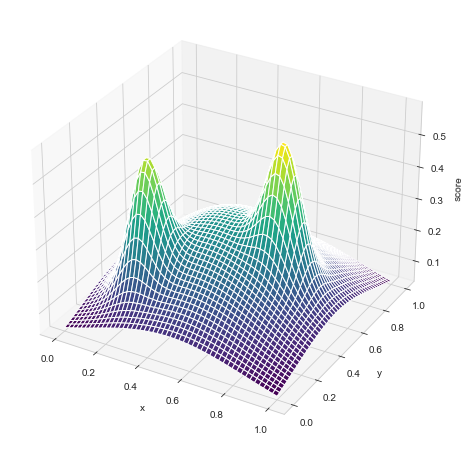

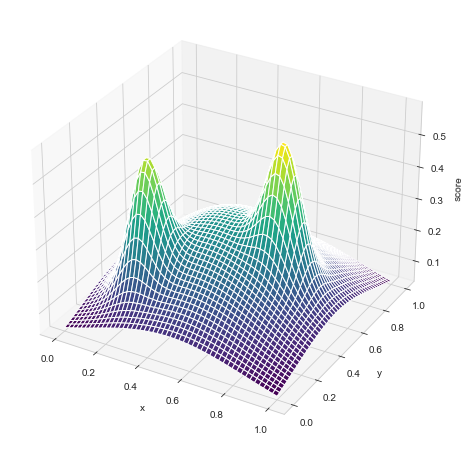

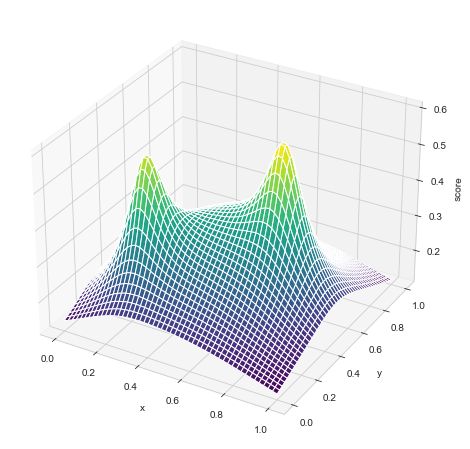

In [132]:

for scores in [scores_se, scores_ga, scores_iq]:
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot_surface(X, Y, scores, cmap='viridis',
                   edgecolor='white')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('score');

    plt.show()